<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


<font color='red'>**Задание:**</font> заполните код в этой тетрадке и выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4). 

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.5.2
IPython 6.2.1

numpy 1.14.0
scipy 1.0.0
pandas 0.22.0
matplotlib 2.1.1
statsmodels 0.8.0
sklearn 0.19.0

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.9.87-linuxkit-aufs
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   : 39a5765ae89d0e9b014e5a9caeca97308191cfd4


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '../../data/user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
knn.fit(X_train, y_train)

print(round(np.mean(cross_val_score(knn, X_train, y_train, cv=skf)),3))
print(round(accuracy_score(y_valid, knn.predict(X_valid)), 3))

0.565
0.584


*<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [12]:
print('0.565, 0.584')

0.565, 0.584


**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)
forest.fit(X_train, y_train)

print(round(forest.oob_score_, 3))
print(round(accuracy_score(y_valid, forest.predict(X_valid)), 3))

0.723
0.735


**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [15]:
print('0.723, 0.735')

0.723, 0.735


**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [9]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [10]:
logit = LogisticRegression(random_state=17, n_jobs=-1)
logit.fit(X_train, y_train)

print(round(np.mean(cross_val_score(logit, X_train, y_train, cv=skf)),3))
print(round(accuracy_score(y_valid, logit.predict(X_valid)), 3))

0.761
0.782


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [11]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, cv=skf, random_state=17, multi_class='multinomial', n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 1.63 s, sys: 110 ms, total: 1.74 s
Wall time: 19 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [19]:
weights = []
for train_index, test_index in skf.split(X_train, y_train):
    weights.append(len(test_index))

logit_mean_cv_scores1 = np.average(list(map(lambda x: x[1], logit_grid_searcher1.scores_.items()))[0], axis=0, weights=weights)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [20]:
best_score_index = np.argmax(logit_mean_cv_scores1)
print('Best C: {0}, best score: {1}'.format(logit_grid_searcher1.Cs_[best_score_index], logit_mean_cv_scores1[best_score_index]))

Best C: 1.0, best score: 0.7590936801463117


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

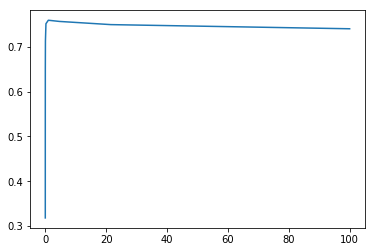

In [21]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [22]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv=skf, random_state=17, multi_class='multinomial', n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 1.85 s, sys: 160 ms, total: 2.01 s
Wall time: 57.1 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [23]:
logit_mean_cv_scores2 = np.average(list(map(lambda x: x[1], logit_grid_searcher2.scores_.items()))[0], axis=0, weights=weights)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [24]:
best_score_index = np.argmax(logit_mean_cv_scores2)
print('Best C: {0}, best score: {1}'.format(logit_grid_searcher2.Cs_[best_score_index], logit_mean_cv_scores2[best_score_index]))

Best C: 0.4631578947368421, best score: 0.758788864052022


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

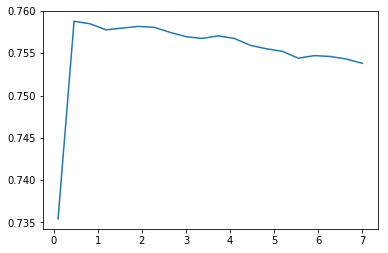

In [25]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [26]:
logit = LogisticRegression(C=logit_grid_searcher2.Cs_[best_score_index], random_state=17, n_jobs=-1)
logit.fit(X_train, y_train)

logit_cv_acc = accuracy_score(y_valid, logit.predict(X_valid))

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [27]:
print(round(logit_mean_cv_scores2[best_score_index], 3))
print(round(logit_cv_acc, 3))

0.759
0.773


**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.svm import LinearSVC

In [11]:
svm = LinearSVC(C=1,random_state=17)
svm.fit(X_train, y_train)

print(round(np.mean(cross_val_score(svm, X_train, y_train, cv=skf)),3))
print(round(accuracy_score(y_valid, svm.predict(X_valid)), 3))

0.753
0.777


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [12]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1, cv=skf, n_jobs=-1, verbose=True)
svm_grid_searcher1.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   27.8s finished


CPU times: user 3.4 s, sys: 40 ms, total: 3.44 s
Wall time: 31.2 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [13]:
print('Best params: {0}'.format(svm_grid_searcher1.best_params_))
print('Best score: {0}'.format(round(svm_grid_searcher1.best_score_, 3)))

Best params: {'C': 6666.666700000001}
Best score: 0.684


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

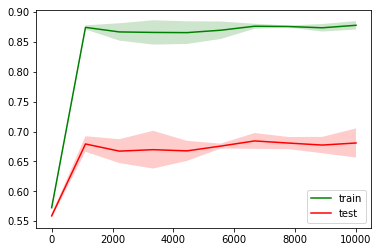

In [14]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [15]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2, cv=skf, n_jobs=-1, verbose=True)
svm_grid_searcher2.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   50.1s finished


CPU times: user 820 ms, sys: 190 ms, total: 1.01 s
Wall time: 50.9 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [16]:
print('Best params: {0}'.format(svm_grid_searcher2.best_params_))
print('Best score: {0}'.format(round(svm_grid_searcher2.best_score_, 3)))

Best params: {'C': 0.10434482758620689}
Best score: 0.765


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

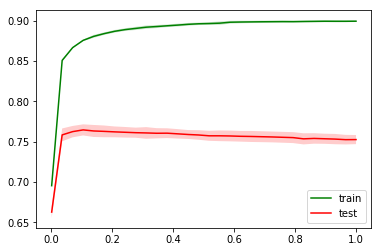

In [17]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [26]:
svm = LinearSVC(C=svm_grid_searcher2.best_params_['C'], random_state=17)
svm.fit(X_train, y_train)

svm_cv_acc = accuracy_score(y_valid, svm.predict(X_valid))

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [27]:
print(round(svm_grid_searcher2.best_score_, 3))
print(round(svm_cv_acc, 3))

0.765
0.781


## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [42]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
        
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, test_size=test_size, random_state=random_state, stratify=y)
    
    svm = LinearSVC(C=estimator.C, random_state=random_state)
    svm.fit(X_train, y_train)
    
    return np.mean(cross_val_score(svm, X_train, y_train, cv=cv, n_jobs=-1)), accuracy_score(y_valid, svm.predict(X_valid))

**Убедитесь, что функция работает.**

In [43]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7646853244550981, 0.7807537331121118)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [44]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [45]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{0}_w{1}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{0}_w{1}.pkl'.format(session_length, window_size))
        (cross, acc) = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3)
        print('X_sparse_10users_s{0}_w{1}: ({2}, {3})'.format(session_length, window_size, round(cross, 3), round(acc, 3)))

X_sparse_10users_s15_w10: (0.824, 0.84)
X_sparse_10users_s10_w10: (0.765, 0.781)
X_sparse_10users_s15_w7: (0.848, 0.854)
X_sparse_10users_s10_w7: (0.797, 0.807)
X_sparse_10users_s7_w7: (0.753, 0.762)
X_sparse_10users_s15_w5: (0.868, 0.875)
X_sparse_10users_s10_w5: (0.816, 0.825)
X_sparse_10users_s7_w5: (0.774, 0.785)
X_sparse_10users_s5_w5: (0.725, 0.736)
CPU times: user 10.7 s, sys: 290 ms, total: 11 s
Wall time: 25.4 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [46]:
print('X_sparse_10users_s15_w5: (0.868, 0.875)')

X_sparse_10users_s15_w5: (0.868, 0.875)


**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [47]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_s{0}_w{1}.pkl'.format(session_length, window_size))
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_s{0}_w{1}.pkl'.format(session_length, window_size))
    (cross, acc) = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3)
    print('X_sparse_150users_s{0}_w{1}: ({2}, {3})'.format(session_length, window_size, round(cross, 3), round(acc, 3)))

X_sparse_150users_s5_w5: (0.409, 0.422)
X_sparse_150users_s7_w7: (0.436, 0.453)
X_sparse_150users_s10_w10: (0.461, 0.484)
CPU times: user 5min 50s, sys: 600 ms, total: 5min 51s
Wall time: 13min 42s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [48]:
print('X_sparse_150users_s10_w10: (0.461, 0.484)')

X_sparse_150users_s10_w10: (0.461, 0.484)


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [28]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [29]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [30]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.Cs_[best_score_index]], cv=skf, random_state=17, multi_class='ovr', n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 3min 5s, sys: 13.3 s, total: 3min 19s
Wall time: 7min 5s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [32]:
weights = []
for train_index, test_index in skf.split(X_train_150,y_train_150):
    weights.append(len(test_index))

cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    user_score = np.average(logit_cv_150users.scores_[user_id], axis=0, weights=weights)[0]
    cv_scores_by_user[user_id] = user_score
    print('User {0}, CV score: {1}'.format(user_id, user_score))

User 256, CV score: 0.9961110589805344
User 640, CV score: 0.9971536705139032
User 258, CV score: 0.9957878494051902
User 259, CV score: 0.995089299677833
User 260, CV score: 0.9972787838979075
User 261, CV score: 0.9896572935889817
User 6, CV score: 0.9958399799818586
User 263, CV score: 0.9926391625744164
User 264, CV score: 0.9966740692085536
User 780, CV score: 0.9964134163252114
User 13, CV score: 0.9962361723645387
User 270, CV score: 0.9889587438616246
User 15, CV score: 0.9951414302545015
User 16, CV score: 0.9917633688863866
User 273, CV score: 0.994422028296477
User 515, CV score: 0.9941926537591359
User 533, CV score: 0.9936609218771179
User 28, CV score: 0.9900326337409945
User 797, CV score: 0.9957357188285216
User 1054, CV score: 0.9964759730172135
User 31, CV score: 0.9945992722571497
User 1040, CV score: 0.9969034437458947
User 33, CV score: 0.9936296435311167
User 859, CV score: 0.9980711686632677
User 1798, CV score: 0.9962674507105398
User 294, CV score: 0.9959442411

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [33]:
class_distr = np.bincount(y_train_150.astype('int'))

acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (len(y_train_150)-class_distr[user_id])/len(y_train_150)

In [34]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [35]:
print(round(num_better_than_default/len(np.unique(y_train_150)), 3))

0.913


**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [20]:
y_binary_128 = list(map(lambda x: 1 if x == 128 else 0, y_150users))

In [21]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [22]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128, train_sizes=train_sizes, cv=skf, scoring='roc_auc')

CPU times: user 22.3 s, sys: 270 ms, total: 22.6 s
Wall time: 22.6 s


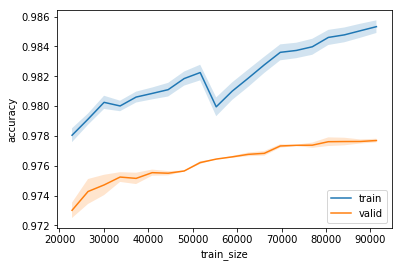

In [23]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.